In [1]:
print('hello world')

hello world


In [2]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

from datasets_code import build_dataloader, build_dataset
from utils.options import parse_options
from train import create_train_val_dataloader
import torch
import numpy as np

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/s94zalek/shape_matching


In [3]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False,
                    opt_path = 'options/train/faust.yaml')

opt['root_path'] = root_path
opt['dist'] = False

opt['datasets']['train_dataset']['return_corr'] = True
opt['datasets']['train_dataset']['return_dist'] = False
opt['datasets']['test_dataset']['return_dist'] = False

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240425_100602


Constructing DatasetFromListOfDicts:   0%|                                                                                      | 0/80 [00:00<?, ?it/s]

Calculating functional maps: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 95.46it/s]
/home/s94zalek/.conda/envs/fmnet/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Calculating functional maps: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 95.47it/s]


In [4]:
Cxy_40 = []
Dx_40 = []
Dy_40 = []

train_dataset = train_loader.dataset
for i in range(len(train_dataset)):
    data = train_dataset[i]
    if data['first']['name'] == 'tr_reg_040':
        
        Cxy_40.append(data['Cxy'])
        
        Dx_40.append(data['first']['evals'])
        Dy_40.append(data['second']['evals'])
        
Cxy_40_full = torch.stack(Cxy_40)
Cxy_40_truncated = torch.stack(Cxy_40)[:, :20, :20]

Dx_40_full = torch.stack(Dx_40)
Dy_40_full = torch.stack(Dy_40)

In [219]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE


def apply_pca_tsne(
    data, data_name,
    color_criterion, color_criterion_name,
    max_points,
    palette,
    show_pairwise,
    scaler,
    ):

    # initialize PCA and TSNE
    pca = PCA(
        n_components=min(20, data.shape[0])
        )
    

    # # scale data
    # if standard_scale:
    #     scaler = StandardScaler()
    # else:
    #     scaler = MinMaxScaler()
    
    data_scaled = scaler.fit_transform(
            data.cpu().numpy().reshape(data.shape[0], -1)
            )
    print('data_scaled shape:', data_scaled.shape)
    
    ###################################################
    # PCA
    ###################################################

    # apply PCA
    data_pca = pca.fit_transform(
        data_scaled
        )
    
    # plot PCA explained variance ratio
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))

    ax[0].plot(pca.explained_variance_ratio_, 'o-')
    ax[0].set_title(f'Explained variance ratio for {data_name}')
    ax[0].set_xlabel('PCA component')
    ax[0].set_ylabel('Explained variance ratio')
    
    ###################################################
    # TSNE
    ###################################################
    
    tsne = TSNE(n_components=2, perplexity=min(30, data.shape[0] / 2))
    # print(tsne.get_params())
    
    data_tsne = tsne.fit_transform(
        data_scaled
        )
    
    tsne_df = pd.DataFrame(data_tsne[:max_points, :], columns=['TSNE_1', 'TSNE_2'])
    tsne_df[color_criterion_name] = color_criterion[:max_points]
    
    sns.scatterplot(data=tsne_df, x='TSNE_1', y='TSNE_2', hue=color_criterion_name, palette=palette,
                    ax=ax[1])
    ax[1].set_title(f'TSNE for {data_name}')


    ###################################################
    # PCA pairwise plots
    ###################################################
    
    if show_pairwise:
        # plot the first principal components
        pca_df = pd.DataFrame(data_pca[:max_points, :show_pairwise], columns=[f'PCA_{i}' for i in range(show_pairwise)])
        pca_df[color_criterion_name] = color_criterion[:max_points]
        
        sns.pairplot(pca_df, diag_kind='kde', hue=color_criterion_name, palette=palette)
        plt.suptitle(f'Pairwise plots of the first {show_pairwise} PCA components for {data_name}')
    
    plt.show()

data_scaled shape: (80, 10000)


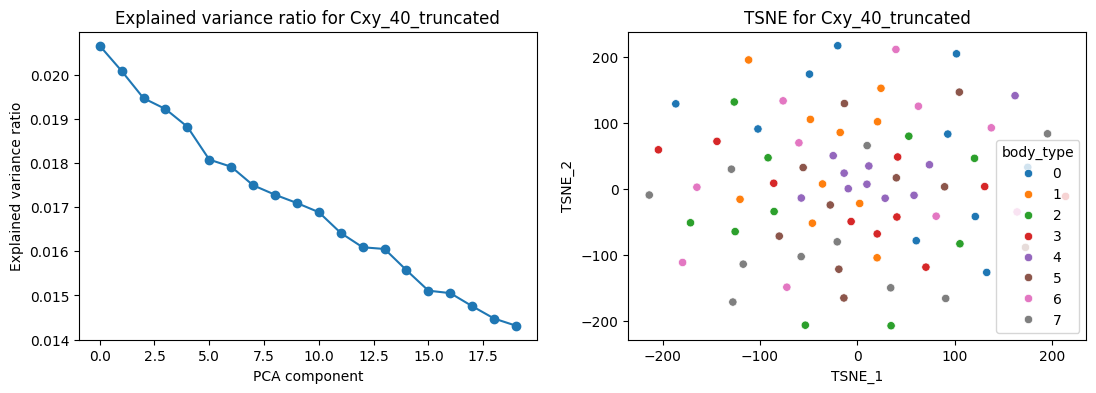

In [80]:
apply_pca_tsne(
    data=Cxy_40_full[:, 50:150, 50:150], 
    data_name='Cxy_40_truncated',
    color_criterion=[i // 10 for i in range(80)],
    color_criterion_name='body_type',
    max_points=1000,
    palette='tab10',
    show_pairwise=False,
    scaler=StandardScaler()
    )

data_scaled shape: (80, 10000)


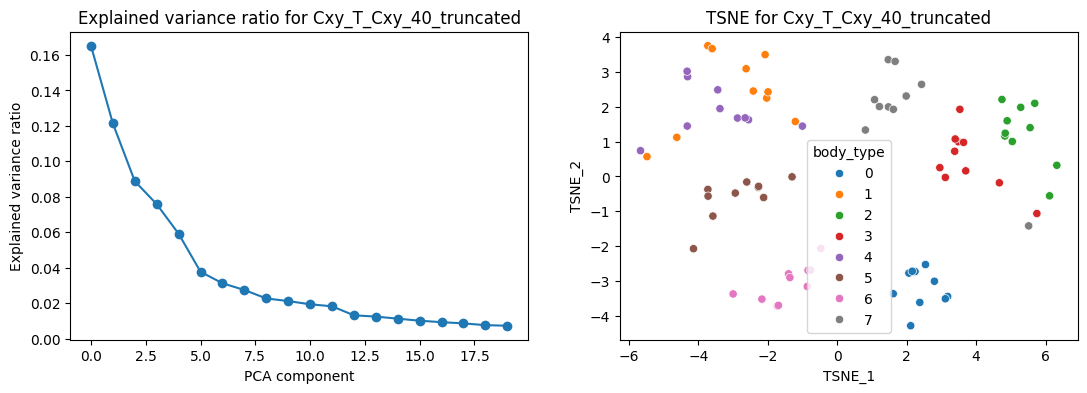

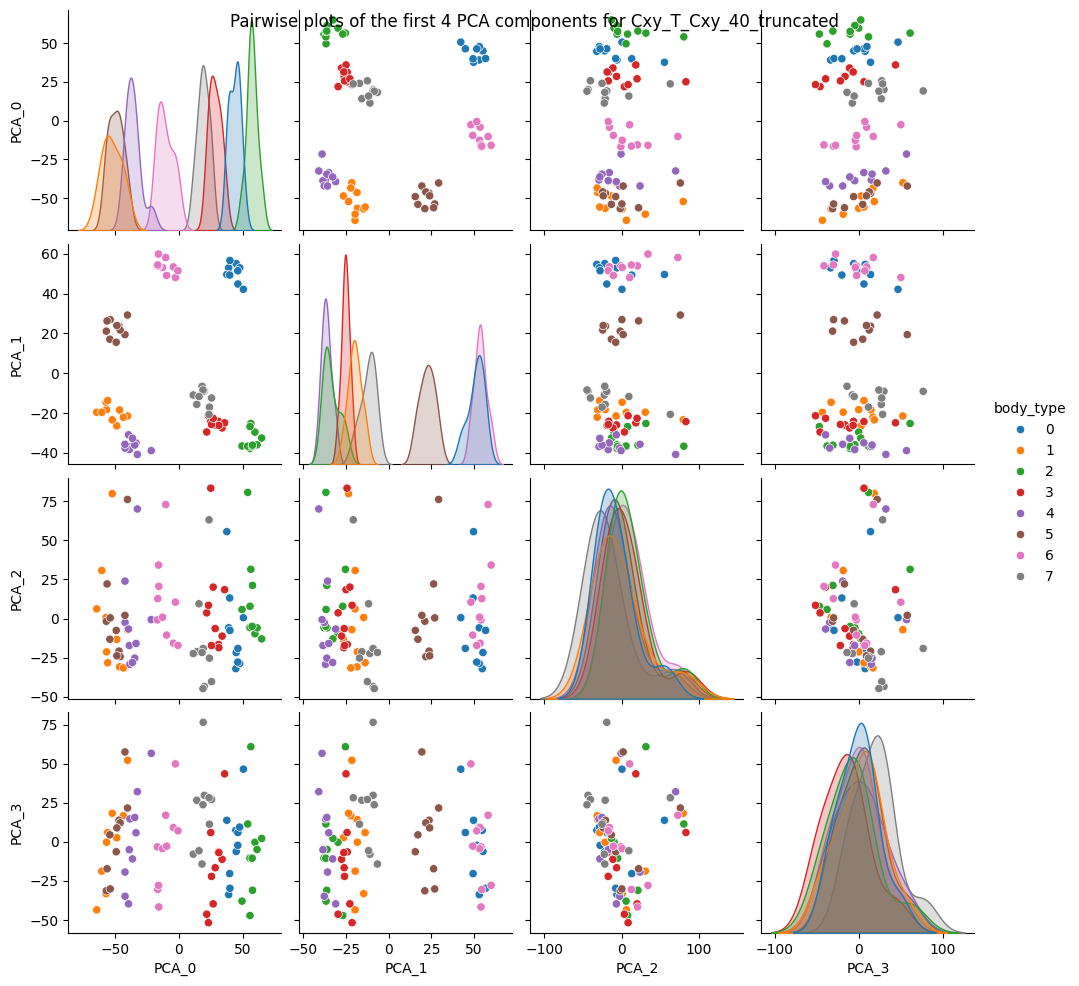

In [93]:
Cxy_T_Cxy_40_full = torch.bmm(Cxy_40_full.transpose(1, 2), Cxy_40_full)
Cxy_T_Cxy_40_truncated = torch.bmm(Cxy_40_full.transpose(1, 2), Cxy_40_full)[:, :20, :20]

apply_pca_tsne(
    data=Cxy_T_Cxy_40_full[:, 100:200, 100:200], 
    data_name='Cxy_T_Cxy_40_truncated',
    color_criterion=[i // 10 for i in range(80)],
    color_criterion_name='body_type',
    max_points=1000,
    palette='tab10',
    show_pairwise=4,
    scaler=StandardScaler()
)

data_scaled shape: (80, 10000)


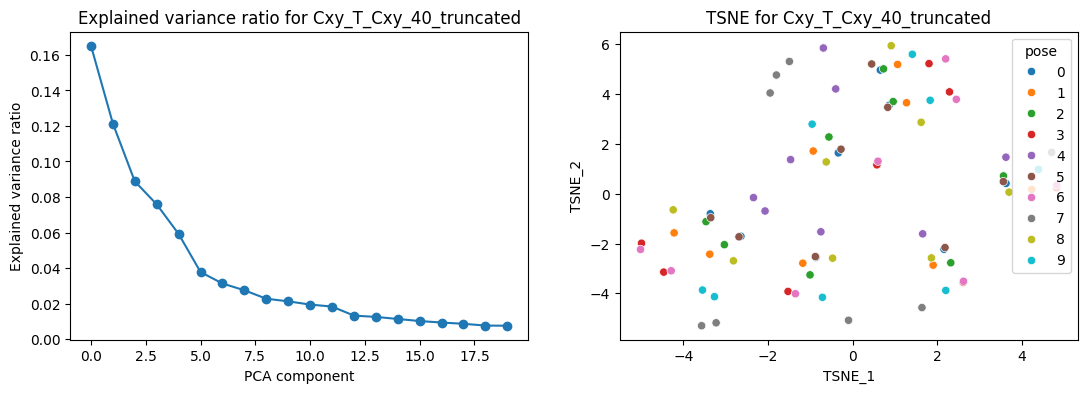

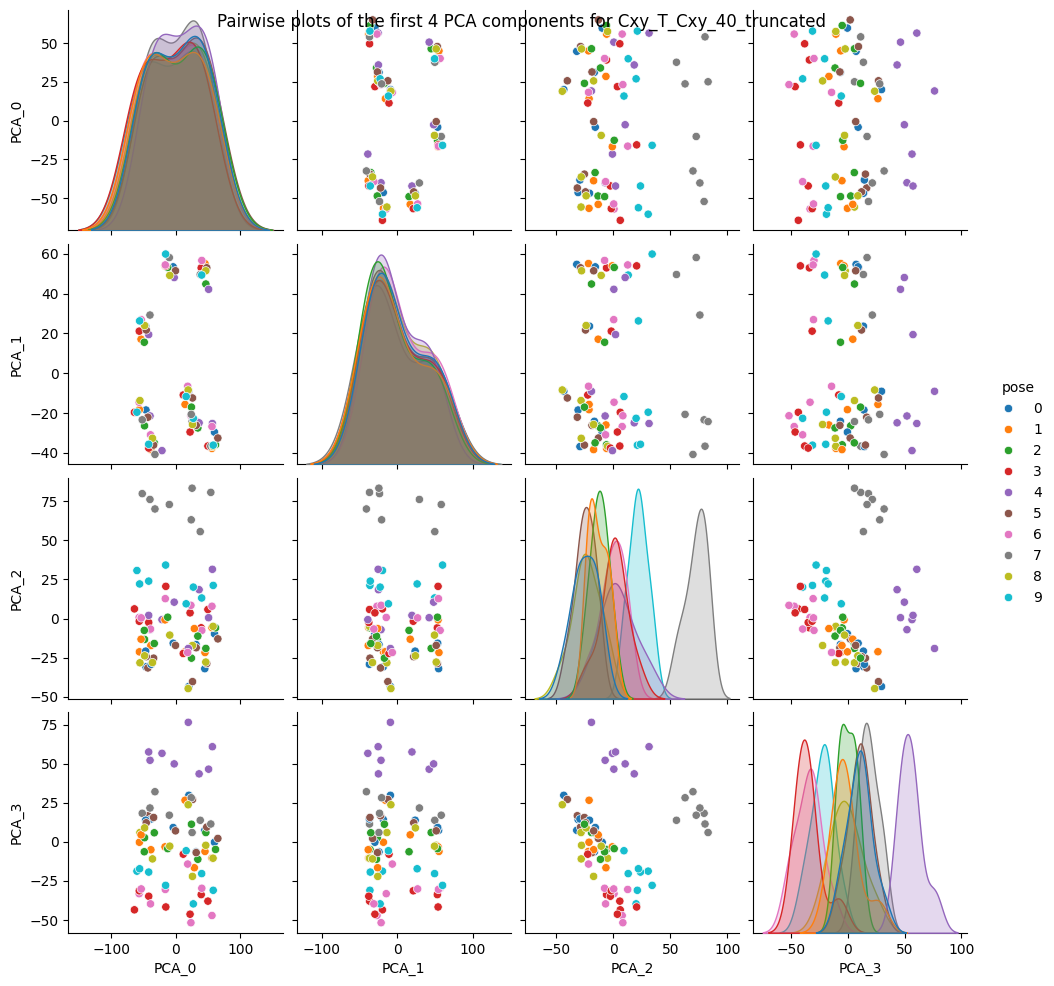

In [94]:
apply_pca_tsne(
    data=Cxy_T_Cxy_40_full[:, 100:200, 100:200], 
    data_name='Cxy_T_Cxy_40_truncated',
    color_criterion=[i % 10 for i in range(80)],
    color_criterion_name='pose',
    max_points=1000,
    palette='tab10',
    show_pairwise=4,
    scaler=StandardScaler()
)

In [20]:
Rmn_40_left = torch.bmm(
    torch.diag_embed(-1 / Dx_40_full),
    Cxy_40_full.transpose(1, 2)
    )
Rmn_40_right = torch.bmm(
    torch.diag_embed(-Dy_40_full),
    Cxy_40_full
    )

Rmn_40_full = torch.bmm(Rmn_40_left, Rmn_40_right)
Rmn_40_truncated = Rmn_40_full[:, :20, :20]

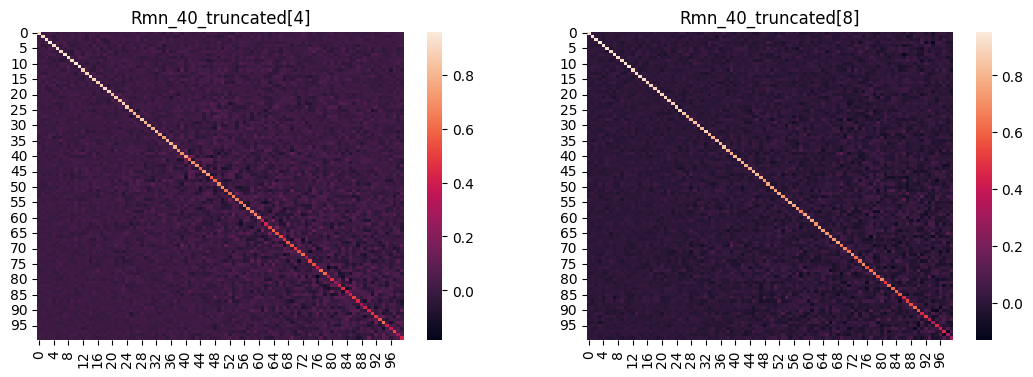

In [87]:
# plot 4 and 8 element of Rmn_40_truncated 

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

sns.heatmap(Rmn_40_full[7, 100:, 100:], ax=ax[0])
ax[0].set_title('Rmn_40_truncated[4]')
sns.heatmap(Rmn_40_full[17, 100:, 100:], ax=ax[1])
ax[1].set_title('Rmn_40_truncated[8]')

plt.show()

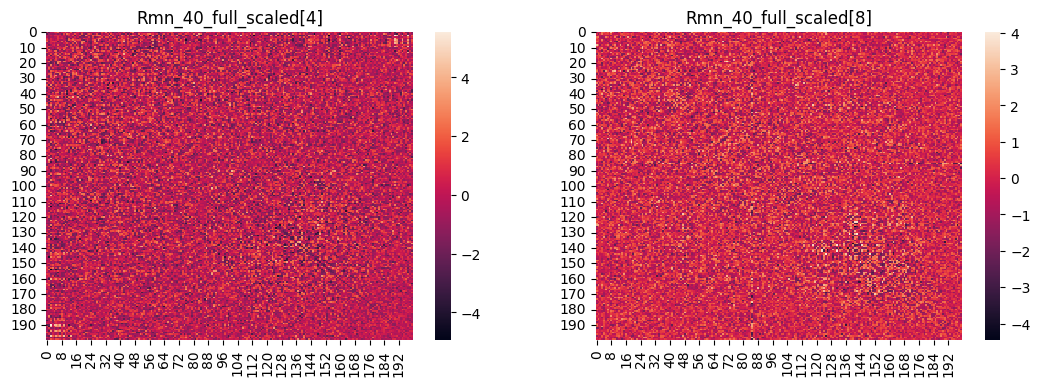

In [88]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler(with_mean=True, with_std=True)

Rmn_40_full_scaled = scaler.fit_transform(
    Rmn_40_full.cpu().numpy().reshape(Rmn_40_full.shape[0], -1)
    )

Rmn_40_full_scaled = torch.tensor(Rmn_40_full_scaled).reshape(Rmn_40_full.shape)

# plot 4 and 8 element of Rmn_40_truncated_scaled

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

sns.heatmap(Rmn_40_full_scaled[7], ax=ax[0])
ax[0].set_title('Rmn_40_full_scaled[4]')
sns.heatmap(Rmn_40_full_scaled[8], ax=ax[1])
ax[1].set_title('Rmn_40_full_scaled[8]')
plt.show()

data_scaled shape: (80, 10000)


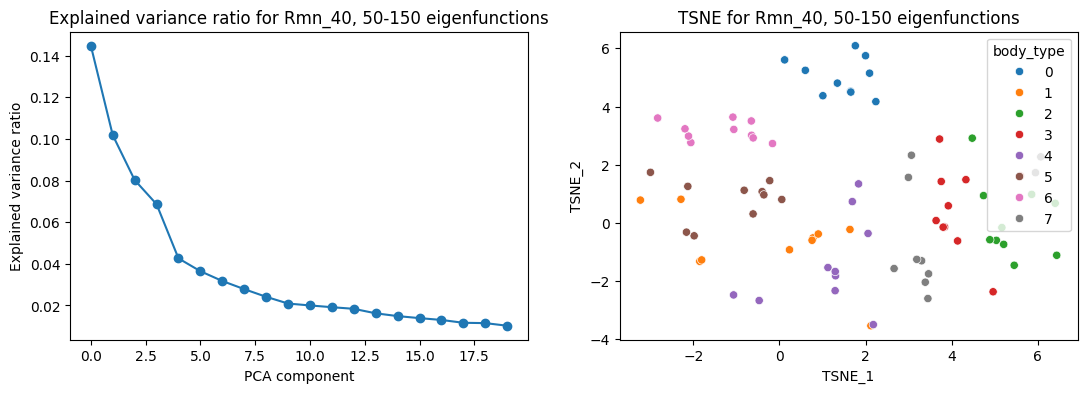

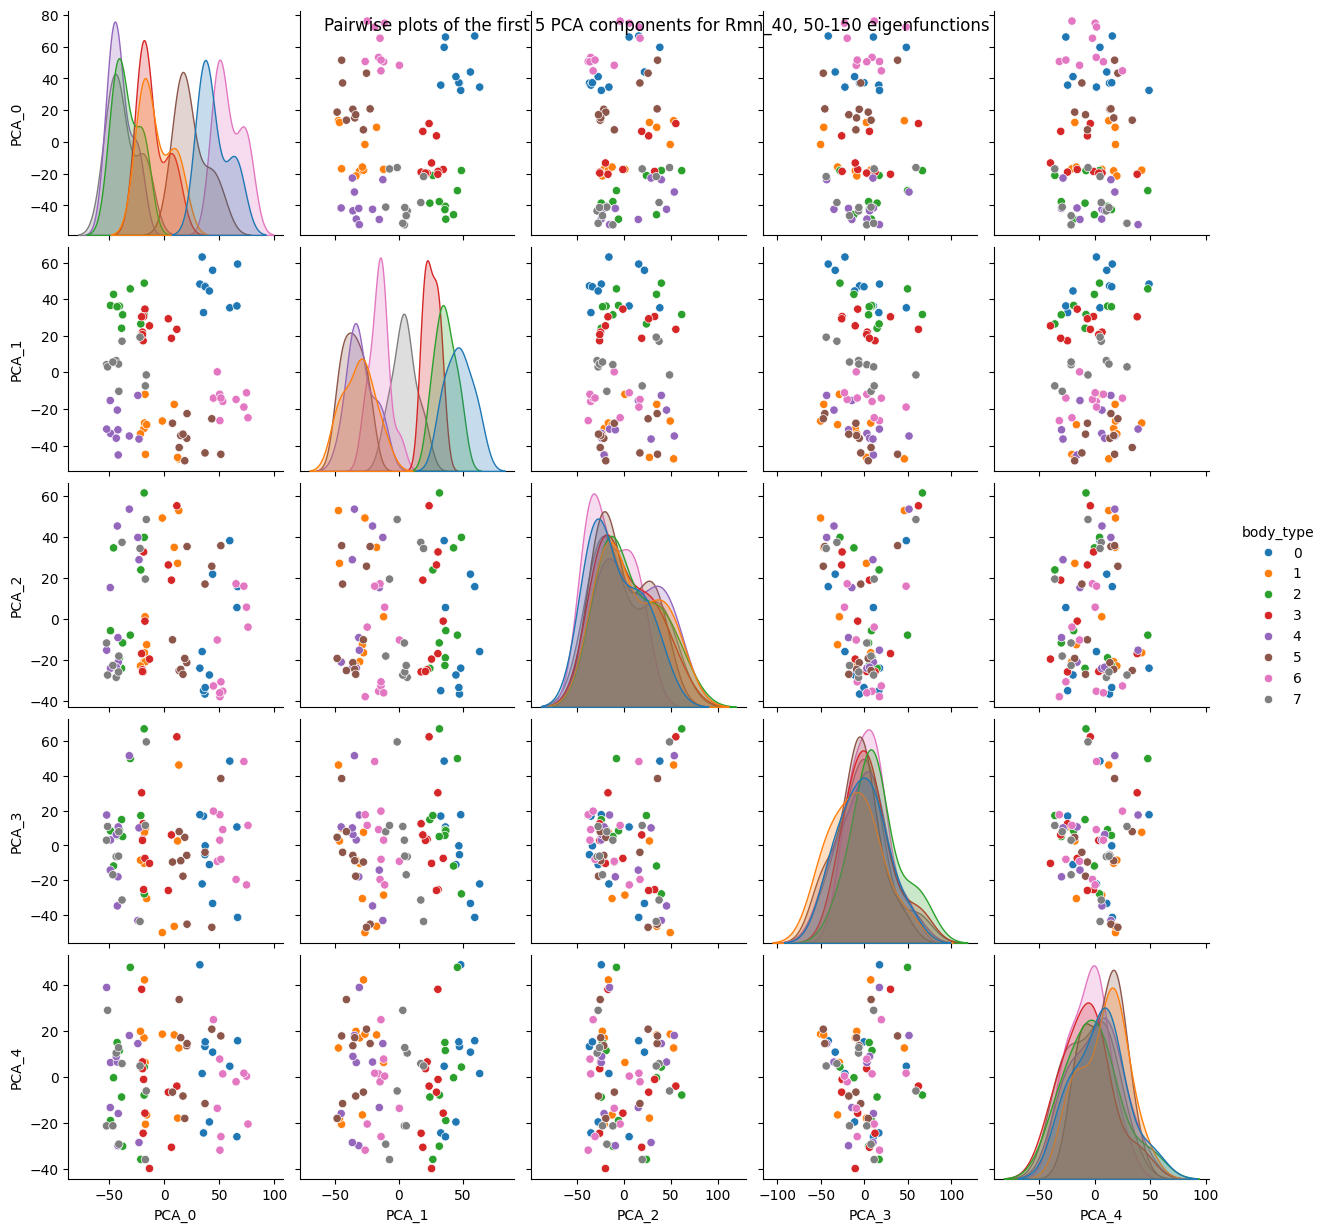

In [227]:
# elements_to_include = []

# for i in range(80):
#     if i % 10 != 7:
#         elements_to_include.append(i)

evec_indices = [i for i in range(200) if i // 4 == 0]

apply_pca_tsne(
    data=Rmn_40_full[:, 50:150, 50:150], 
    data_name='Rmn_40, 50-150 eigenfunctions',
    color_criterion= [i // 10 for i in range(80)],
    color_criterion_name='body_type',
    max_points=1000,
    palette='tab10',
    show_pairwise=5,
    scaler=StandardScaler(with_mean=True, with_std=True),
    # scaler=MinMaxScaler(),
)

data_scaled shape: (80, 10000)


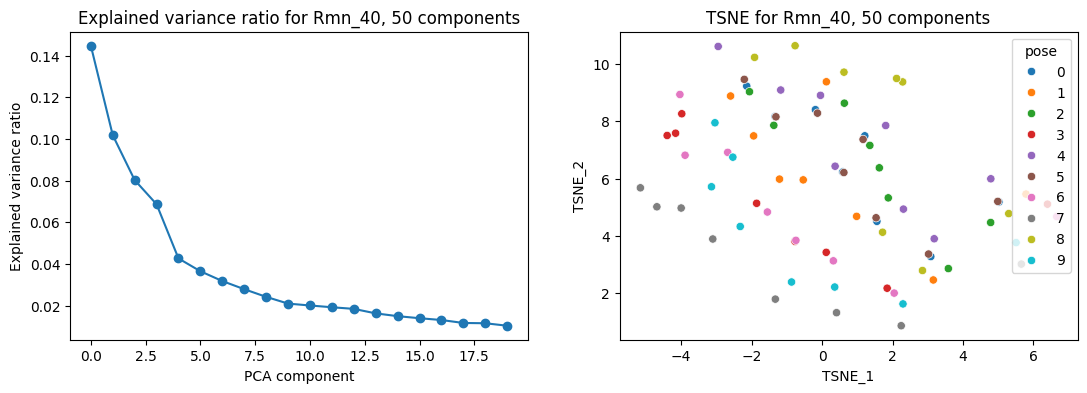

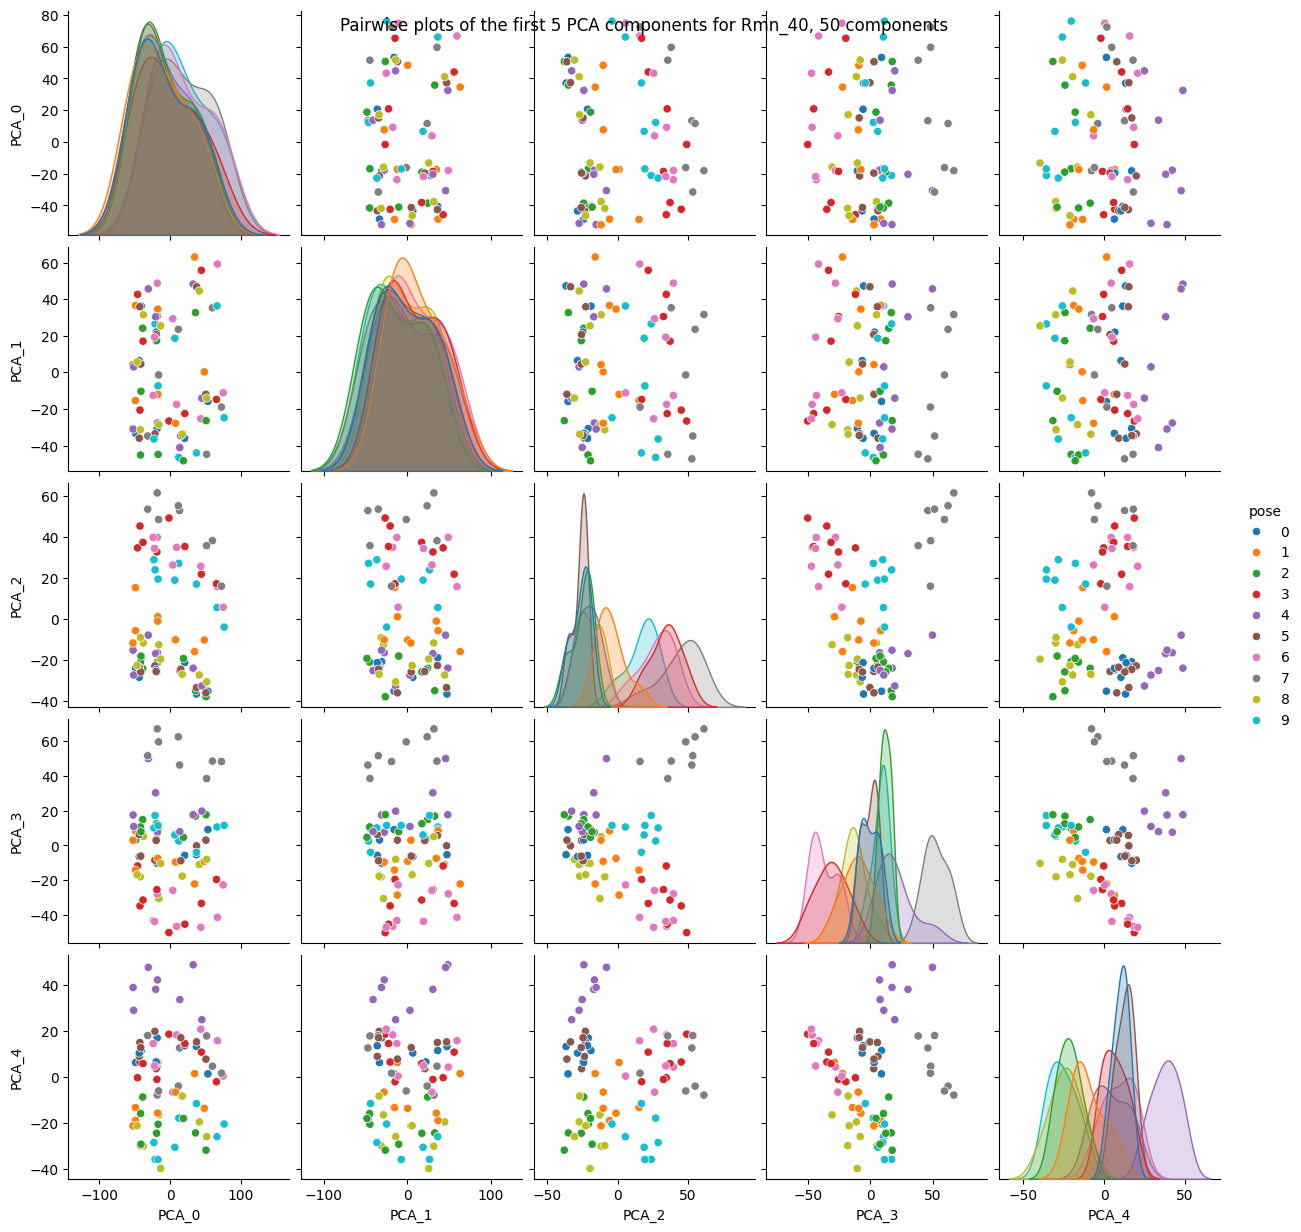

In [228]:
apply_pca_tsne(
    data=Rmn_40_full[:, 50:150, 50:150], 
    data_name='Rmn_40, 50 components',
    color_criterion=[i % 10 for i in range(80)],
    color_criterion_name='pose',
    max_points=1000,
    palette='tab10',
    show_pairwise=5,
    scaler=StandardScaler(with_mean=True, with_std=True)
)

0 - 50: almost no clusters
0 - 100: some clusters, very blurry
0 - 150: clusters visible, but not well separated, many intersections
0 - 200: better clusters than before, still not perfectly separable

150 - 200: body type separated almost perfectly, pose very bad
100 - 200: body good again, pose a bit better but still bad
50 - 150: both are ok



# Full dataset

In [12]:
Cxy_d = []
Dx_d = []
Dy_d = []

names_d = []
names_y_d = []

train_dataset = train_loader.dataset
for i in range(len(train_dataset)):
    data = train_dataset[i]
        
    Cxy_d.append(data['Cxy'])
    
    Dx_d.append(data['first']['evals'])
    Dy_d.append(data['second']['evals'])
    
    names_d.append(data['first']['name'])
    names_y_d.append(data['second']['name'])
        
Cxy_d_full = torch.stack(Cxy_d)
Cxy_d_truncated = torch.stack(Cxy_d)[:, :20, :20]

Dx_d_full = torch.stack(Dx_d)
Dy_d_full = torch.stack(Dy_d)

data_scaled shape: (6400, 400)


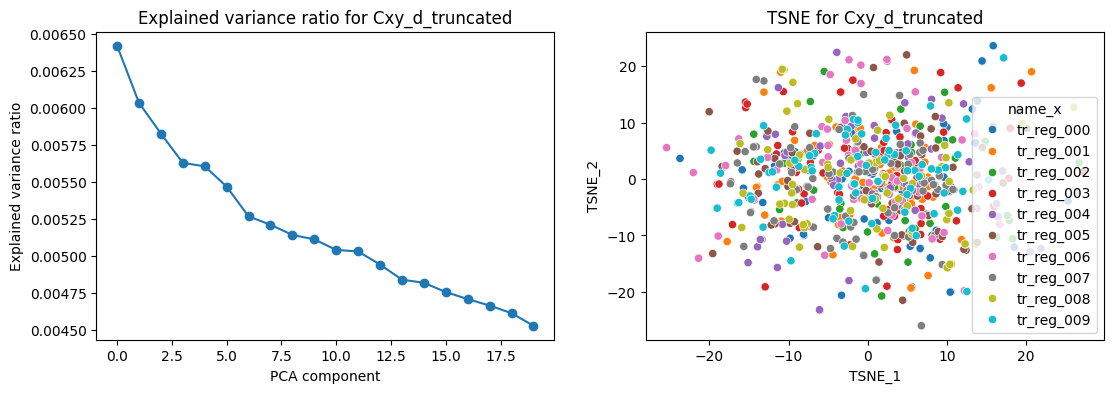

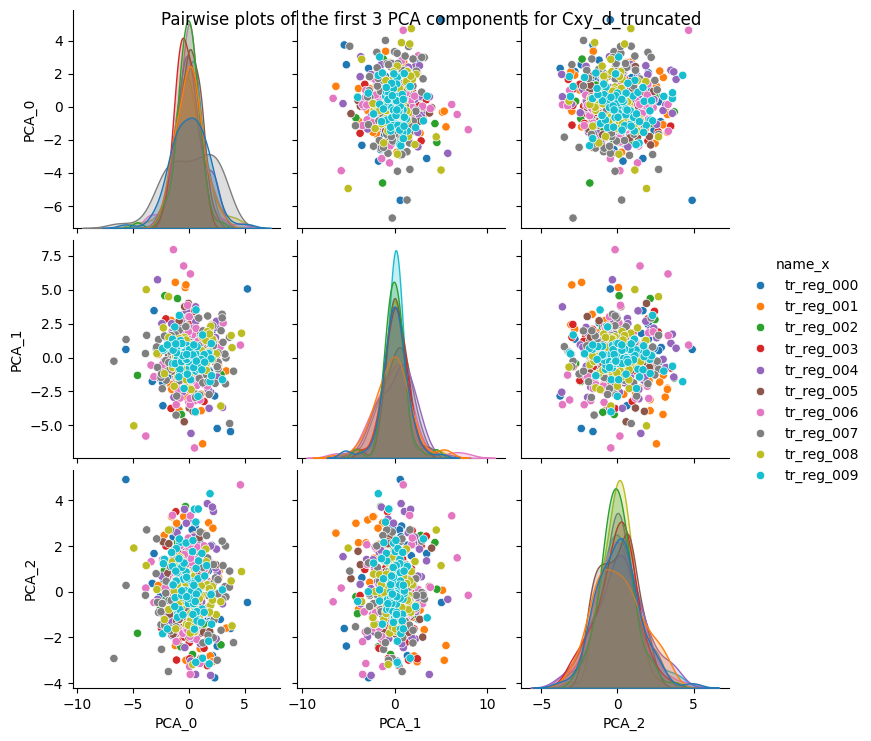

In [13]:
apply_pca_tsne(
    data=Cxy_d_truncated, 
    data_name='Cxy_d_truncated',
    color_criterion=names_d,
    color_criterion_name='name_x',
    max_points=800,
    palette='tab10',
    show_pairwise=3,
    scaler=StandardScaler()
    )

data_scaled shape: (6400, 400)


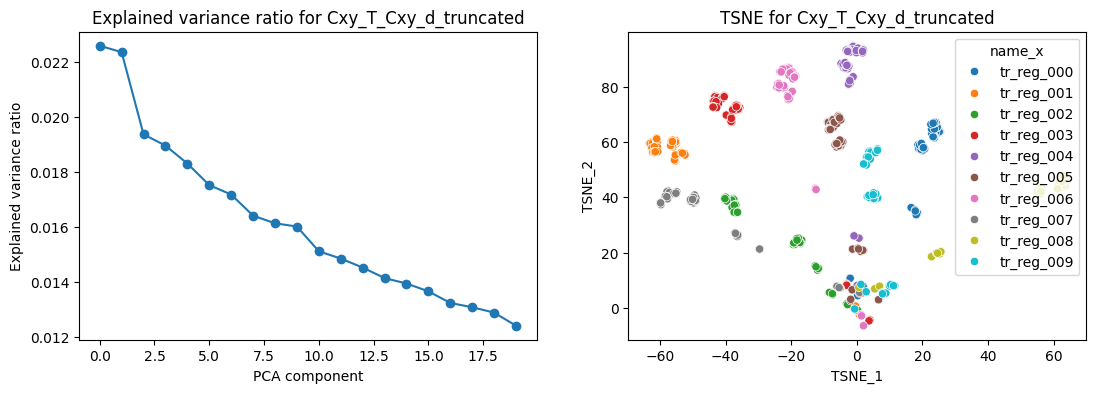

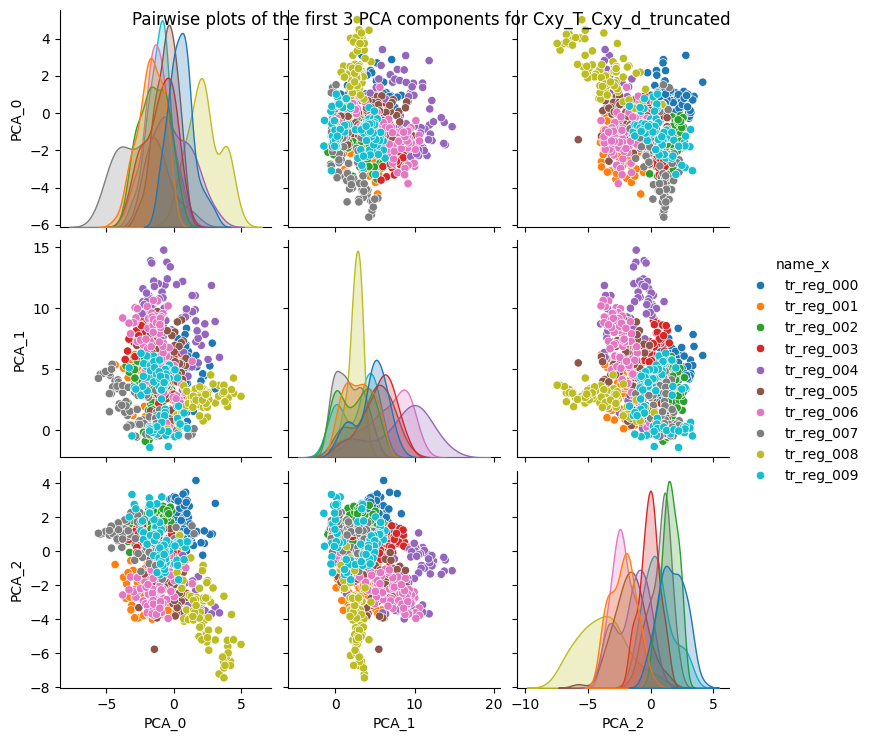

In [14]:
Cxy_T_Cxy_d_truncated = torch.bmm(Cxy_d_full.transpose(1, 2), Cxy_d_full)[:, :20, :20]

apply_pca_tsne(
    data=Cxy_T_Cxy_d_truncated, 
    data_name='Cxy_T_Cxy_d_truncated',
    color_criterion=names_d,
    color_criterion_name='name_x',
    max_points=800,
    palette='tab10',
    show_pairwise=3,
    scaler=StandardScaler()
)

In [15]:
Rmn_d_left = torch.bmm(
    torch.diag_embed(-1 / Dx_d_full),
    Cxy_d_full.transpose(1, 2)
    )
Rmn_d_right = torch.bmm(
    torch.diag_embed(-Dy_d_full),
    Cxy_d_full
    )

Rmn_d_full = torch.bmm(Rmn_d_left, Rmn_d_right)
Rmn_d_truncated = Rmn_d_full[:, :20, :20]

data_scaled shape: (6400, 400)


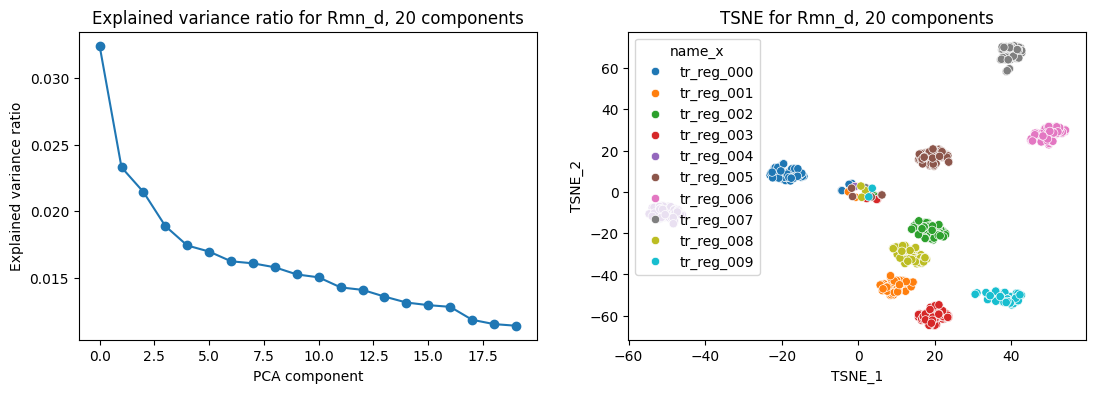

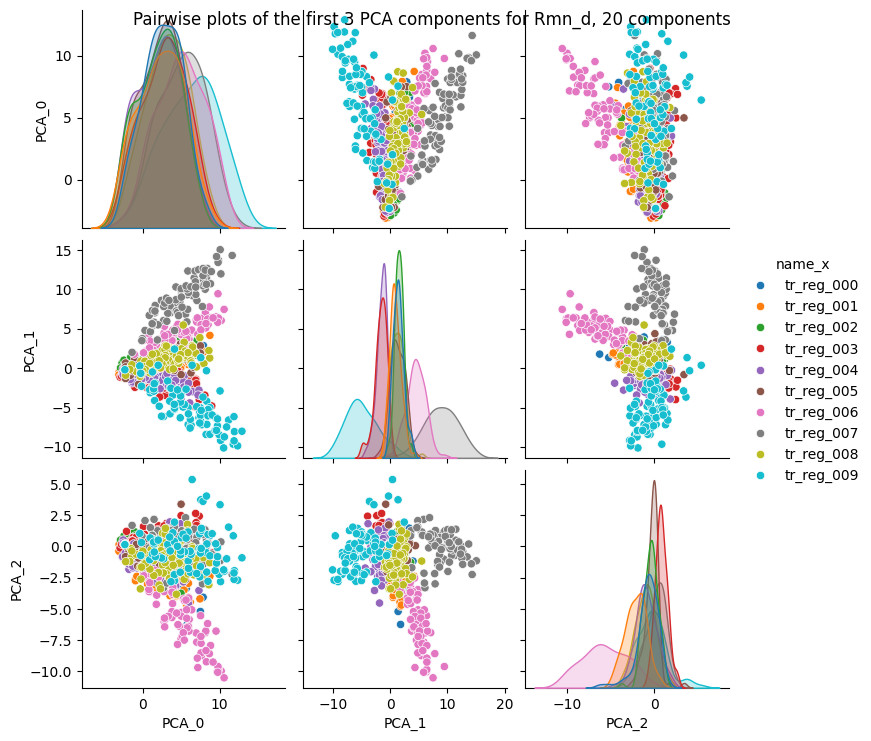

In [16]:
apply_pca_tsne(
    data=Rmn_d_truncated, 
    data_name='Rmn_d, 20 components',
    color_criterion=names_d,
    color_criterion_name='name_x',
    max_points=800,
    palette='tab10',
    show_pairwise=3,
    scaler=StandardScaler()
)

# Variability localization

In [ ]:
import trimesh

scene = trimesh.Scene()

In [206]:
variability_C = data_x['evecs'] @ Cxy_T_Cxy_40_full[30]
variability_C.shape

torch.Size([4999, 200])

In [204]:
variability_C[0, :].shape

torch.Size([200])

In [188]:
Cxy_T_Cxy_40_full[46]

tensor([[ 1.0000e+00,  8.2465e-03, -3.3260e-05,  ..., -9.8231e-03,
         -7.8054e-03, -1.5045e-02],
        [ 8.2465e-03,  9.9878e-01,  6.1288e-04,  ...,  1.0911e-05,
          2.2035e-03, -4.6179e-03],
        [-3.3260e-05,  6.1288e-04,  9.9410e-01,  ...,  9.4165e-03,
          1.1540e-02, -1.0996e-02],
        ...,
        [-9.8231e-03,  1.0911e-05,  9.4165e-03,  ...,  4.1075e-01,
          9.6349e-03,  1.1365e-01],
        [-7.8054e-03,  2.2035e-03,  1.1540e-02,  ...,  9.6349e-03,
          3.3080e-01,  2.1366e-02],
        [-1.5045e-02, -4.6179e-03, -1.0996e-02,  ...,  1.1365e-01,
          2.1366e-02,  2.8966e-01]])

In [209]:
scene.geometry.clear()

mesh = trimesh.Trimesh(
            vertices=data_x['verts'].cpu().numpy(),
            faces=data_x['faces'].cpu().numpy()
            )
cmap = trimesh.visual.color.interpolate(variability_C[:, 20], 'bwr')
mesh.visual.vertex_colors = cmap[:len(mesh.vertices)]

scene.add_geometry(mesh)
scene.show()

In [202]:
cmap.shape

(200, 4)